In [1]:
import casadi as cs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_dynamics(L=0.1) -> cs.Function:
    state = cs.SX.sym("x", 5)
    control = cs.SX.sym("u", 2)

    heading, v, steer = state[2], state[3], state[4]  # x, y, phi, v, psi
    acc, psi_dot = control[0], control[1]  # acceleration and yaw rate

    state_dot = cs.vertcat(
        v * cs.cos(heading),
        v * cs.sin(heading),
        v * cs.tan(steer) / L,
        acc,
        psi_dot,
    )

    return cs.Function("dynamics", [state, control], [state_dot])


def create_linearized_dynamics(L=0.1) -> cs.Function:
    state = cs.SX.sym("x", 5)
    control = cs.SX.sym("u", 2)

    dyn = create_dynamics(L=L)
    state_dot = dyn(state, control)

    A = cs.jacobian(state_dot, state)
    B = cs.jacobian(state_dot, control)

    return cs.Function("linearized_dynamics", [state, control], [A, B])


dyn = create_dynamics()
lin_dyn = create_linearized_dynamics()

In [3]:
class MPC:
    def __init__(self) -> None:
        self.N = 20  # prediction horizon
        self.dt = 0.01  # time step
        self.L = 1  # wheelbase
        self.n_states = 5
        self.n_controls = 2

        self.dyn = create_dynamics(L=self.L)
        self.lin_dyn = create_linearized_dynamics(L=self.L)

        self.opti = cs.Opti()
        self._create()

    def _create(self):
        cost = 0
        constraints = []

        # Variables
        self.X = self.opti.variable(self.n_states, self.N + 1)
        self.U = self.opti.variable(self.n_controls, self.N)

        # Initial state
        self.X0 = self.opti.parameter(self.n_states)

        # Reference
        self.Xref = self.opti.parameter(self.n_states, self.N + 1)
        self.Uref = self.opti.parameter(self.n_controls, self.N)

        # Constraint on first state
        constraints.append(self.X[:, 0] == self.X0)

        # Cost function
        self.Q = self.opti.parameter(self.n_states, self.n_states)
        self.R = self.opti.parameter(self.n_controls, self.n_controls)

        # A, B = self.lin_dyn(self.X[:, 0], self.U[:, 0] * 0)

        for i in range(self.N):
            xe = self.X[:, i] - self.Xref[:, i]
            ue = self.U[:, i] - self.Uref[:, i]

            cost += xe.T @ self.Q @ xe + ue.T @ self.R @ ue

            # nonlinear dynamics
            fx = self.dyn(self.X[:, i], self.U[:, i])
            x_next_est = self.X[:, i] + fx * self.dt
            constraints.append(self.X[:, i + 1] == x_next_est)

            # A, B = self.lin_dyn(self.Xref[:, i], self.Uref[:, i])
            # dxdt = A @ xe + B @ ue
            # # fx = self.dyn(self.X[:, i], self.U[:, i])
            # x_next_est = self.X[:, i] + (dxdt) * self.dt
            # constraints.append(self.X[:, i + 1] == x_next_est)

        # Terminal cost
        xe = self.X[:, self.N] - self.Xref[:, self.N]
        cost += xe.T @ self.Q @ xe * 10

        # Maximum acceleration is 10 m/s^2
        constraints.append(self.opti.bounded(-10, self.U[0, :], 10))
        # Maximum steering angle is 60 degrees
        # max_steering = np.deg2rad(60)
        # constraints.append(self.opti.bounded(-max_steering, self.X[4, :], max_steering))

        self.opti.minimize(cost)
        self.opti.subject_to(constraints)

        opts = {
            "ipopt.print_level": 0,
        }

        self.opti.solver("ipopt", opts)

    def solve(self, x0, x_ref, u_ref, Q, R):
        self.opti.set_value(self.X0, x0)
        self.opti.set_value(self.Xref, x_ref)
        self.opti.set_value(self.Uref, u_ref)
        self.opti.set_value(self.Q, Q)
        self.opti.set_value(self.R, R)

        self.opti.solve()

        return self.opti.value(self.X), self.opti.value(self.U)

In [4]:
state0 = np.array([0, 0, 0, 0, 0])
state_ref = np.array([10, 10, 0, 0, 0])

Q = np.diag([1, 1, 1, 1, 1])
R = np.diag([1, 1]) * 1e-3

mpc = MPC()

# x_ref = np.tile(state_ref, (mpc.N + 1, 1)).T
# X_ref is linear interpolation between state0 and state_ref
x_ref = np.zeros((5, mpc.N + 1))
for i in range(5):
    x_ref[i, :] = np.linspace(state0[i], state_ref[i], mpc.N + 1)
# now generate a reference heading based on the reference trajectory
x_ref[4, :-1] = np.arctan2(np.diff(x_ref[1, :]), np.diff(x_ref[0, :]))

u_ref = np.zeros((2, mpc.N))

states, controls = mpc.solve(state0, x_ref, u_ref, Q, R)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  92.00us (  7.08us)  93.71us (  7.21us)        13
       nlp_g  |  73.00us (  5.62us)  73.25us (  5.63us)        13
  nlp_grad_f  | 156.00us ( 11.14us) 157.32us ( 11.24us)        14
  nlp_hess_l  | 554.00us ( 46.17us) 560.76us ( 46.73us)        12
   nlp_jac_g  | 461.00us ( 32.93us) 330.99us ( 23.64us)        14
       total  |   4.37ms (  4.37ms)   4.26ms (  4.26ms)         1


In [ ]:
sim_steps = 3000  # simulate for 10 seconds

history_states = []
history_target = []

current_state = state0.copy()
for stepi in range(sim_steps):
    ti = stepi * mpc.dt

    # target should move linearly in x
    # target should move sine wave in y
    state_ref[0] = 10
    state_ref[1] = 1  # * np.sin(2 * np.pi * ti)
    history_target.append(state_ref.copy())

    x_ref = np.zeros((5, mpc.N + 1))
    for i in range(5):
        x_ref[i, :] = np.linspace(current_state[i], state_ref[i], mpc.N + 1)
    # now generate a reference heading based on the reference trajectory
    x_ref[2, :-1] = np.arctan2(np.diff(x_ref[1, :]), np.diff(x_ref[0, :]))
    u_ref = np.zeros((2, mpc.N))

    states, controls = mpc.solve(current_state, x_ref, u_ref, Q, R)

    first_control = controls[:, 0]

    # apply first control input
    current_state = (
        current_state + dyn(current_state, first_control).toarray().flatten() * mpc.dt
    )
    # steering is limited
    # current_state[4] = np.clip(current_state[4], -np.deg2rad(60), np.deg2rad(60))

    history_states.append(current_state.copy())

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  79.00us (  7.18us)  78.18us (  7.11us)        11
       nlp_g  |  60.00us (  5.45us)  57.81us (  5.26us)        11
  nlp_grad_f  | 141.00us ( 11.75us) 142.25us ( 11.85us)        12
  nlp_hess_l  | 482.00us ( 48.20us) 485.15us ( 48.52us)        10
   nlp_jac_g  | 280.00us ( 23.33us) 280.83us ( 23.40us)        12
       total  |   3.49ms (  3.49ms)   3.51ms (  3.51ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  94.00us (  6.71us)  94.93us (  6.78us)        14
       nlp_g  |  67.00us (  4.79us)  67.65us (  4.83us)        14
  nlp_grad_f  | 156.00us ( 10.40us) 155.59us ( 10.37us)        15
  nlp_hess_l  | 582.00us ( 44.77us) 582.95us ( 44.84us)        13
   nlp_jac_g  | 323.00us ( 21.53us) 327.62us ( 21.84us)        15
       total  |   4.05ms (  4.05ms)   4.06ms (  4.06ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:165:
.../casadi/core/optistack_internal.cpp:1030: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

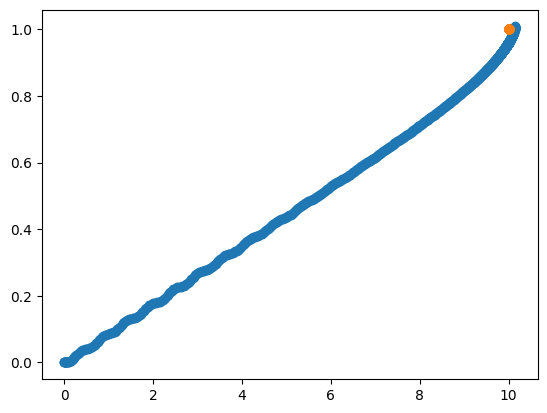

In [ ]:
history_states = np.array(history_states)

plt.figure()
plt.scatter(history_states[:, 0], history_states[:, 1], label="MPC")
plt.scatter(
    np.array(history_target)[:, 0], np.array(history_target)[:, 1], label="Target"
)

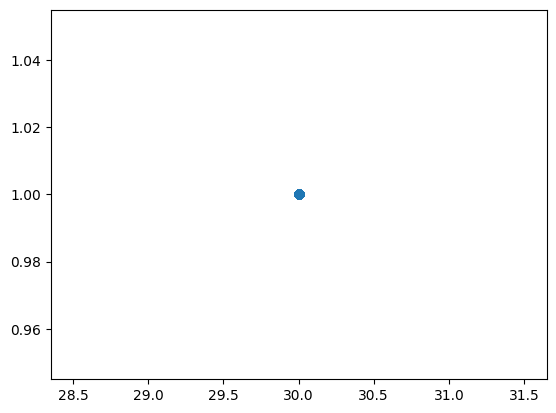

In [ ]:
plt.scatter(
    np.array(history_target)[:, 0], np.array(history_target)[:, 1], label="Target"
)